In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Loading of best performing model

In [6]:
from model import Inception, get_model
from data_manipulation import IMAGE_DIM, get_image_generators

model = get_model()
model.build(input_shape=(None, IMAGE_DIM, IMAGE_DIM, 3))
model.load_weights('best_models/more_train_data-lr0.0003.h5')
train_generator, test_generator = get_image_generators({'batch_size': 1})

Found 16469 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.


# Examples of augmented data

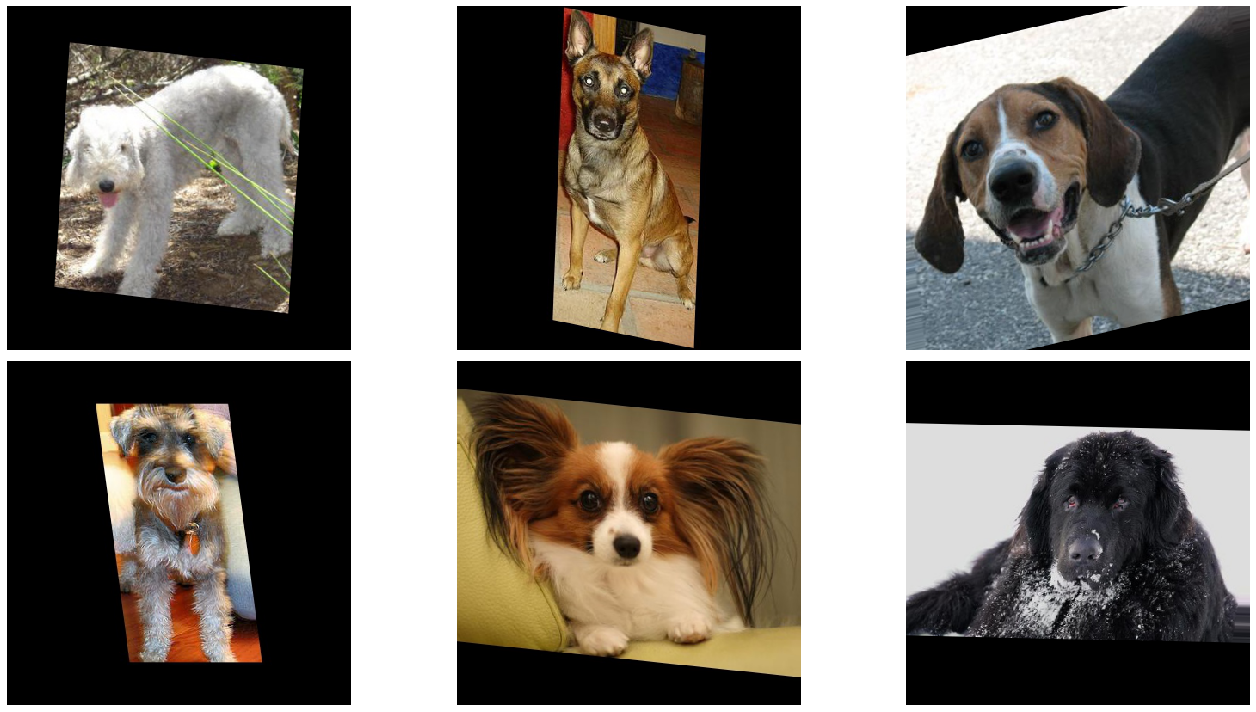

In [4]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in train_generator:
        plt.imshow((x[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_3 (Inception)      multiple                  36160     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 multiple                  0         
_________________________________________________________________
inception_4 (Inception)      multiple                  173952    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 multiple                  0         
_________________________________________________________________
inception_5 (Inception)      multiple                  691968    
_________________________________________________________________
max_pooling2d_11 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                 

# Evaluation

In [7]:
predictions = model.predict_generator(test_generator,steps = len(test_generator.classes))

In [8]:
INDEX_TO_CLASS = {value: key for key, value in test_generator.class_indices.items()}

In [21]:
def same_order(a,b):
    if a < b:
        return a,b
    return b,a

def get_stats(labels, predictions, prediction_tries=1):
    """
    Prediction tries means how many of how many of the
    largest probabilitiest are accepted as correct prediction
    """
    CLASS_COUNT = len(predictions[0])
    correct = 0.
    class_accuracies = {class_index: 0. for class_index in range(CLASS_COUNT)}
    class_counts = {class_index: 0. for class_index in range(CLASS_COUNT)}
    class_similarities = {}
    for label, prediction in zip(labels, predictions):
        if label in prediction.argsort()[-prediction_tries:]:
            correct += 1
            class_accuracies[label] += 1
        else:
            a,b = same_order(label, prediction.argsort()[-1])
            key = f'{INDEX_TO_CLASS[a]}|{INDEX_TO_CLASS[b]}'
            if key in class_similarities:
                class_similarities[key] += 1
            else:
                class_similarities[key] = 1
        class_counts[label] += 1
    class_accuracies = {
        INDEX_TO_CLASS[class_name]: class_accuracies[class_name] / class_counts[class_name] 
        for class_name
        in class_accuracies
    }
    print(correct)
    print(len(labels))
    return correct / len(labels), class_accuracies, class_similarities

In [26]:
accuracy, class_accuracies, class_similarities = get_stats(test_generator.classes, predictions, prediction_tries=1)
print(f'Accuracy: {accuracy}')

3059.0
4111
Accuracy: 0.7441011919241061


In [29]:
two_guesses_accuracy, _, _ = get_stats(test_generator.classes, predictions, prediction_tries=1)
print(f'Two guesses accuracy: {two_guesses_accuracy}')

3059.0
4111
Two guesses accuracy: 0.7441011919241061


In [24]:
def get_top_values(value_dict, top_count=10):
    items = list(value_dict.items())
    items.sort(key=lambda t: t[1], reverse=True)
    labels = [i[0] for i in items[:top_count]]
    values = [i[1] for i in items[:top_count]]
    return labels, values

def plot_values(labels, values):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.barh(labels[::-1], values[::-1])
    plt.xticks(rotation=90)
    plt.show()

# Most accurate classified classes

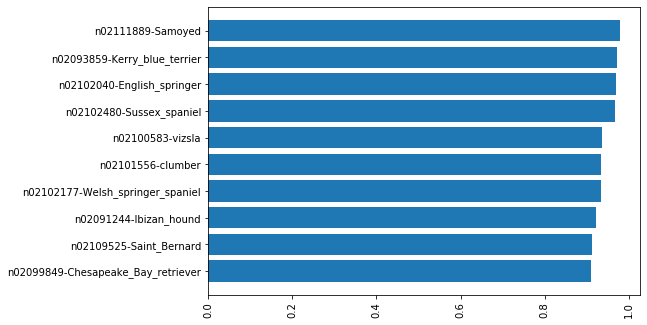

In [25]:
labels, values = get_top_values(class_accuracies)
plot_values(labels, values)

# Most missclassified breeds pairs

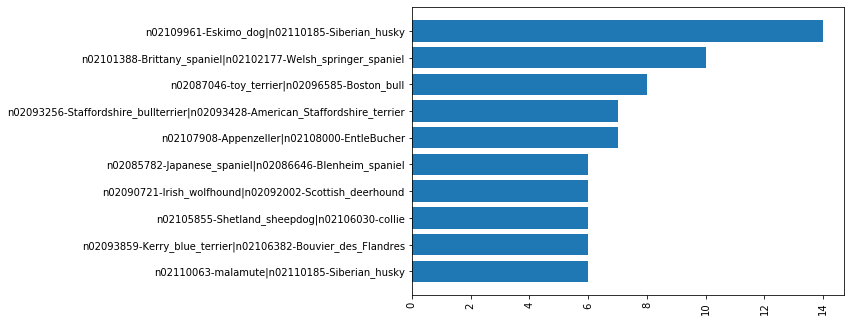

In [18]:
labels, values = get_top_values(class_similarities)
plot_values(labels, values)

In [411]:
def get_path(class_name,image_name):
    return f'./dog_breeds_data/test/{class_name}/{image_name}'

def show_similar_classes(class1, class2):
    plt.figure(figsize=(20,10))
    for i in range(4):
        plt.subplot(2,4,i+1)
        image_f =os.listdir(f'./dog_breeds_data/test/{class1}')[:4][i]
        img = load_img(get_path(class1, image_f))
        plt.imshow(img)
    for i in range(4):
        plt.subplot(2,4,i+5)
        image_f =os.listdir(f'./dog_breeds_data/test/{class2}')[:4][i]
        img = load_img(get_path(class2, image_f))
        plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [429]:
def split_classes(classes):
    split = classes.split('|')
    return split[0], split[1]

# TOP 3 misclassified breeds visualized
## Top row one breed, bottom row the other

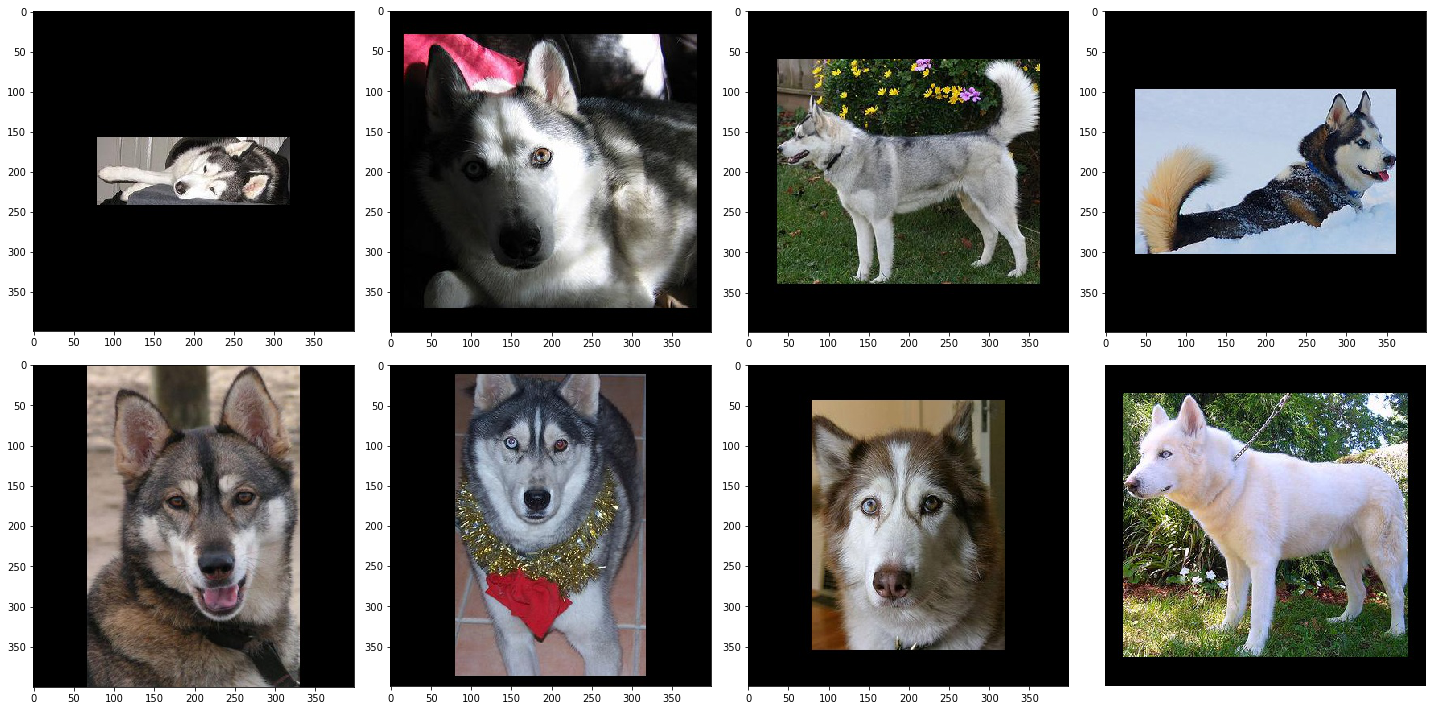

In [437]:

class1, class2 = split_classes(labels[0])
show_similar_classes(class1, class2)

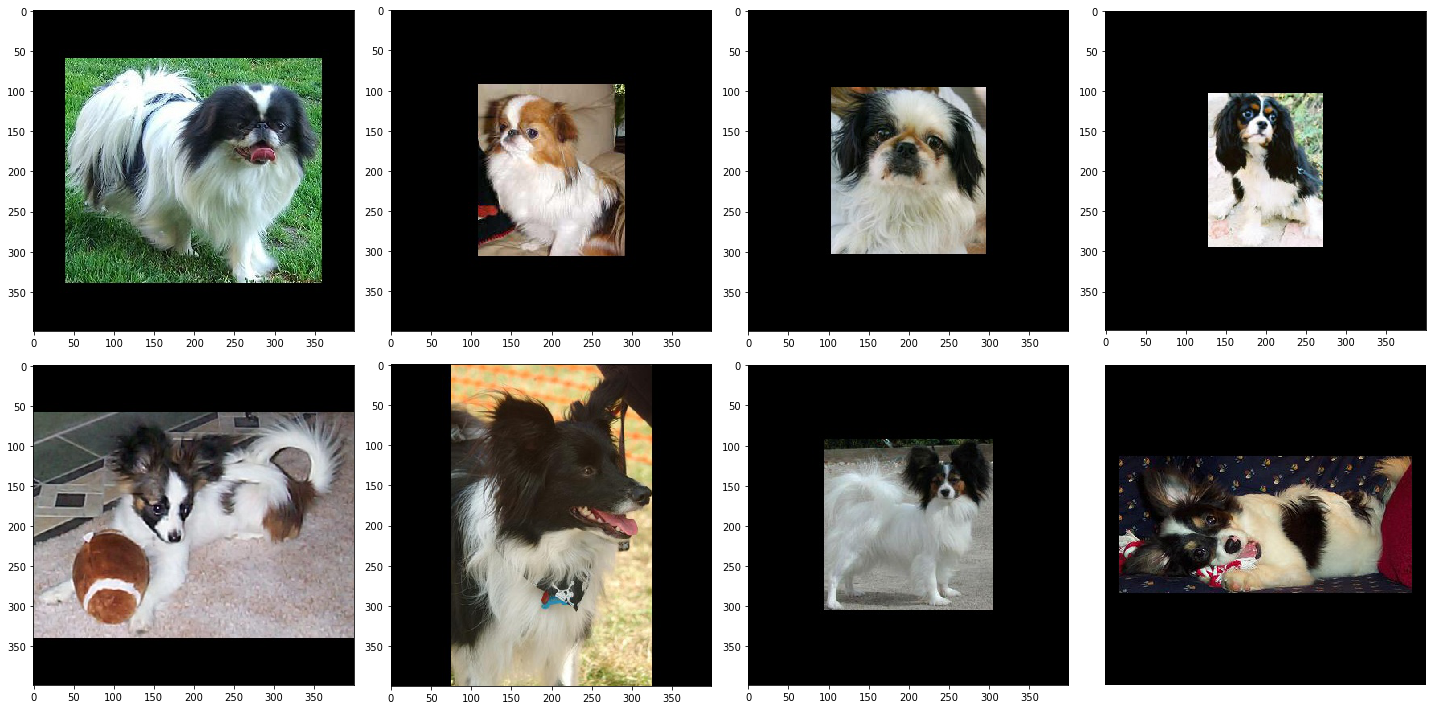

In [431]:
class1, class2 = split_classes(labels[1])
show_similar_classes(class1, class2)

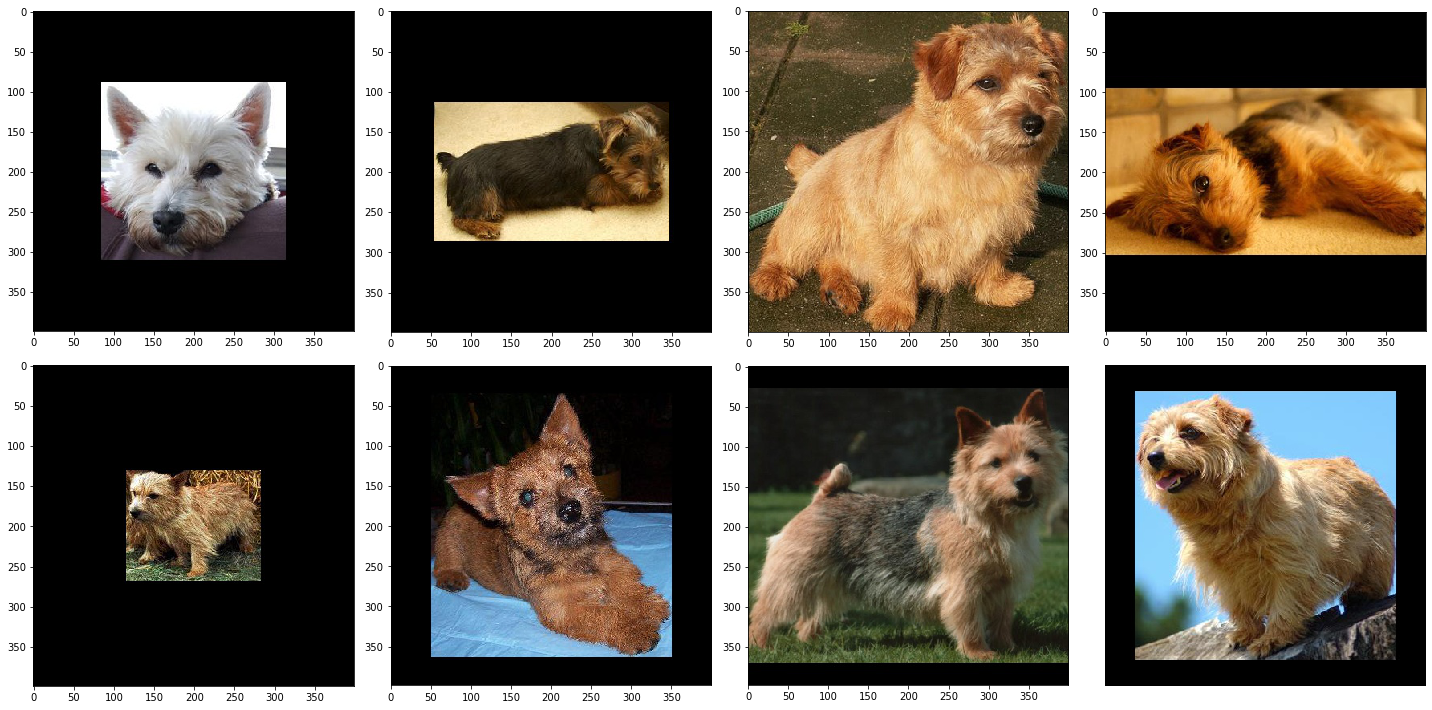

In [433]:
class1, class2 = split_classes(labels[2])
show_similar_classes(class1, class2)

In [93]:
def get_img_arrays(image_paths):
    images = [load_img(img_path, target_size=(IMAGE_DIM, IMAGE_DIM)) for img_path in image_paths]
    preprocessed = [img_to_array(img)/255 for img in images]
    return np.array(preprocessed)

In [134]:
img_arrays = get_img_arrays(['dog_breeds_data/test/n02111129-Leonberg/n02111129_844.jpg'])

In [220]:
len(train_generator.classes)

23900

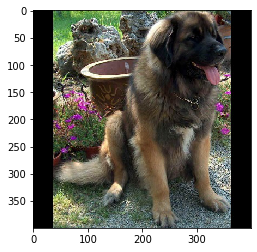

In [226]:
from matplotlib import pyplot as plt
plt.imshow(img_arrays[0], interpolation='nearest')
plt.show()

In [127]:
test_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [136]:
prediction = model.predict(img_arrays)[0]
# img_arrays.shape

In [264]:
predictions[10].argsort()

array([ 14,  82,  90,  87,  77,  72,  26,  88,  73,  83,  49,  63,  81,
       109,  23,  32,  46,  54,  80,  13,  84,  45,  89,  19,  36, 105,
         6,  78,  66,  97,  37,  15,   1, 103,  98,  61,  55,  50, 106,
         9,  75,  95, 110,  31,  70,  16,  24,  86,  52, 100,  44,  99,
        39,  43,  85,  30,   2,  71,  74, 116,  96,   3,  65,  79, 104,
        18,  41,  47,  34,   4, 102,  92, 119,  76,  48,  28,  10,  67,
       107,  93,  59,  40,   5,  57,  42,  21,  11,  22,  64,  25,  35,
        91,   7, 115, 111,  38,  56,  29,   8,  53,  68,  51, 114,  27,
       112, 113, 101,   0,  12,  33,  58,  62,  17, 108, 117,  94,  20,
       118,  69,  60])

In [246]:
test_generator.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)